In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [4]:
def read_csv(file):
    #čitanje csva
    df = pd.read_csv(file,usecols=['id','time'], parse_dates=['time'], encoding='latin1')
    #print(df)
    return df

In [5]:
def get_limits(month, year):
    if month!=12:
        end=pd.to_datetime("{}-{}-01 23:59:59".format(year,month+1))-pd.Timedelta(days=1)
    else:
        end=pd.to_datetime("{}-{}-01 23:59:59".format(year+1,1))-pd.Timedelta(days=1)
    beginning=pd.to_datetime("{}-{}-01 00:00:00".format(year,month))
    #print(end,beginning)
    return end, beginning

In [6]:
def calculate_diff(df, column, beginning, end):
    #oduzimanje susjednih redaka
    df['diff']=df[column].diff(periods=1)    
     #izračun razmaka između poč. mjeseca i prvog mjerenja
    df.loc[0,'diff']=df.loc[0, column] - beginning
    #izračun razmaka između kraja mjeseca i zadnjeg mjerenja
    df.loc[len(df)] = {'diff':end - df.loc[len(df)-1, column], column: end}

In [7]:
def filter_rows(step,df):
    df['index'] = range(len(df))
    df2=df[df['diff'] > step]
    #filtiranje samo redaka čiji je diff veci od odabranog step-a (i njihovih prethodnika)
    previous_row = df2['index'] - 1
    result = pd.concat([df[df['index'].isin(previous_row) ], df2])
    result.sort_index(inplace=True, ignore_index=True)
    #print(result)
    return result

In [8]:
def make_table(result, beginning,step):
    #print(result)
    if result.loc[0,'index']==0 and result.loc[0,'diff']>step:
        #prvi red ima rupu od poč. mjeseca tj prvi snimljeni trenutak je upao u trenutke s rupom
        new_df=pd.DataFrame({'start-time':[beginning], 'end-time':[result.loc[0,'time']], 'duration':[result.loc[0,'diff']]})
        #print(new_df)
        new_df=pd.concat([new_df,pd.DataFrame({
        'start-time': result['time'].iloc[1::2].reset_index(drop=True),
        'end-time': result['time'].iloc[2::2].reset_index(drop=True),
        'duration': result['diff'].iloc[2::2].reset_index(drop=True)
        })], ignore_index=True)
        #print(new_df)
    else:
        #nema rupe od poč. mjeseca, uzimam parove redaka
        new_df = pd.DataFrame({
            'start-time': result['time'].iloc[0::2].reset_index(drop=True),
            'end-time': result['time'].iloc[1::2].reset_index(drop=True),
            'duration': result['diff'].iloc[1::2].reset_index(drop=True)
        })
    return new_df

In [9]:
def obrada(month, year, step):
    #step definira koja je granica za rupu
    df = read_csv("bojler\{}\{}_{}.csv".format(year,month,year))
    end, beginning = get_limits(month, year)
    #nijedan podatak nije zabiljezen u mjesecu
    if df.empty:
        df=pd.DataFrame({'start-time':[beginning], 'end-time':[end], 'duration':[end-beginning]})
        return df
    #izračun rupa između mjerenja
    calculate_diff(df,'time', beginning, end)
    #print(df)
    #filtriranje rupa vecih od stepa
    result = filter_rows(step,df)
    if(result.empty):
        print("nema rupa")
        return result
    #formiranje tablice u obliku start - end - duration
    final_result = make_table(result, beginning,step)
    print(final_result)
    return final_result

In [10]:
def generate_all_timestamps(beginning, end, frequency):
    all_timestamps = pd.date_range(start=beginning, end=end, freq=frequency)
    return all_timestamps

In [11]:
def check_holes(all_timestamps, df):
    is_within_interval_list = [
        any((timestamp >= row['start-time']) and (timestamp <= row['end-time']) for i, row in df.iterrows())
        for timestamp in all_timestamps
    ]
    return is_within_interval_list
    

In [12]:
def check_holes_better(all_timestamps, df, beginning):
    is_within_interval_list = []
    i = 0
    #print(df['start-time'].iloc[0], beginning)
    if df['start-time'].iloc[0]==beginning:
        i+=1
        is_within_interval_list.append(True)
    for index, row in df.iterrows():
        while i < len(all_timestamps) and all_timestamps[i] <= row['start-time']:
            is_within_interval_list.append(False)
            i += 1
        while i < len(all_timestamps) and all_timestamps[i] > row['start-time'] and all_timestamps[i] < row['end-time']:
            is_within_interval_list.append(True)
            i += 1
    while i < len(all_timestamps):
        is_within_interval_list.append(False)
        i += 1
    return is_within_interval_list

In [ ]:
def create_graph(ax, all_timestamps, beginning, end, month, interval_list,step,pctg):
    
    ax.plot(all_timestamps, interval_list, linewidth=0.1)
    tick_positions = pd.date_range(start=beginning, end=end, freq='2D')
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([timestamp.strftime('%Y-%m-%d') for timestamp in tick_positions], rotation=45, ha='right', fontsize=8)
    
    ax.set_xlabel('Timestamp', fontsize=10)
    ax.set_ylabel('1 - rupa, 0 - zapis')
    ax.set_title("rupa:>{}s, postotak:{}%".format(int(step.total_seconds()), round(pctg,2)))
    
    #fig.set_size_inches(20, 6)  # Adjust the width and height as needed
    #plt.savefig("{}m_graph.png".format(month), dpi=600, bbox_inches='tight')
    return


In [ ]:
def make_graph(month,year, steps, save):
    print("{}. mjesec".format(month))
    end, beginning = get_limits(month, year)
    #generiranje svih 'trenutaka' u mjesecu kad bi podaci trebali biti upisani
    all_timestamps = generate_all_timestamps(beginning, end, '1S')
    #stvaranje novog prozora za novi mjesec
    fig, ax = plt.subplots(nrows=1, ncols=len(steps), figsize=(20, 5))
    fig.suptitle("{}. mjesec {}.".format(month,year))
    k=0
    for step in steps:
        df=obrada(month,year,step)
        #true za trenutke koji su u rupi, false za one koji nisu
        interval_list = check_holes_better(all_timestamps, df, beginning)
        percentage = interval_list.count(True)/len(interval_list)*100
        print("Postotak rupa: {} %, rupa: {}".format(round(percentage,2),step))
        #stvaranje grafa
        if len(steps)==1:
            create_graph(ax, all_timestamps, beginning, end, month, interval_list, step, percentage)
        else:   
            create_graph(ax[k], all_timestamps, beginning, end, month, interval_list, step, percentage)
        k+=1
    #plt.title("{}. mjesec".format(month))
    if save:
        plt.savefig("{}_{}_graph.png".format(month,year), dpi=600, bbox_inches='tight')
    plt.show() 
    return



In [ ]:
steps=[pd.to_timedelta('00:00:02'),pd.to_timedelta('00:00:03'),pd.to_timedelta('00:00:05'),pd.to_timedelta('00:00:07'),pd.to_timedelta('00:00:10')]

make_graph(1,2023,steps, True)
#for i in range(4,12):
 #  make_graph(i, step)

In [ ]:
make_graph(12,2022,[pd.to_timedelta('00:00:02')], True)

In [ ]:
steps=[pd.to_timedelta('00:00:02'),pd.to_timedelta('00:00:03'),pd.to_timedelta('00:00:05'),pd.to_timedelta('00:00:07'),pd.to_timedelta('00:00:10')]
for i in range (4,13):
    make_graph(i,2022,steps, True)
for i in range(1,12
               ):
    make_graph(i,2023,steps, True)


               start-time            end-time        duration
0     2023-01-01 00:00:25 2023-01-01 00:00:28 0 days 00:00:03
1     2023-01-01 00:01:18 2023-01-01 00:01:21 0 days 00:00:03
2     2023-01-01 00:02:03 2023-01-01 00:02:06 0 days 00:00:03
3     2023-01-01 00:03:06 2023-01-01 00:03:09 0 days 00:00:03
4     2023-01-01 00:03:41 2023-01-01 00:03:44 0 days 00:00:03
...                   ...                 ...             ...
27699 2023-01-30 23:53:50 2023-01-30 23:53:53 0 days 00:00:03
27700 2023-01-30 23:55:21 2023-01-30 23:55:24 0 days 00:00:03
27701 2023-01-30 23:57:02 2023-01-30 23:57:05 0 days 00:00:03
27702 2023-01-30 23:58:51 2023-01-30 23:58:54 0 days 00:00:03
27703 2023-01-31 00:00:00 2023-01-31 23:59:59 0 days 23:59:59

[27704 rows x 3 columns]


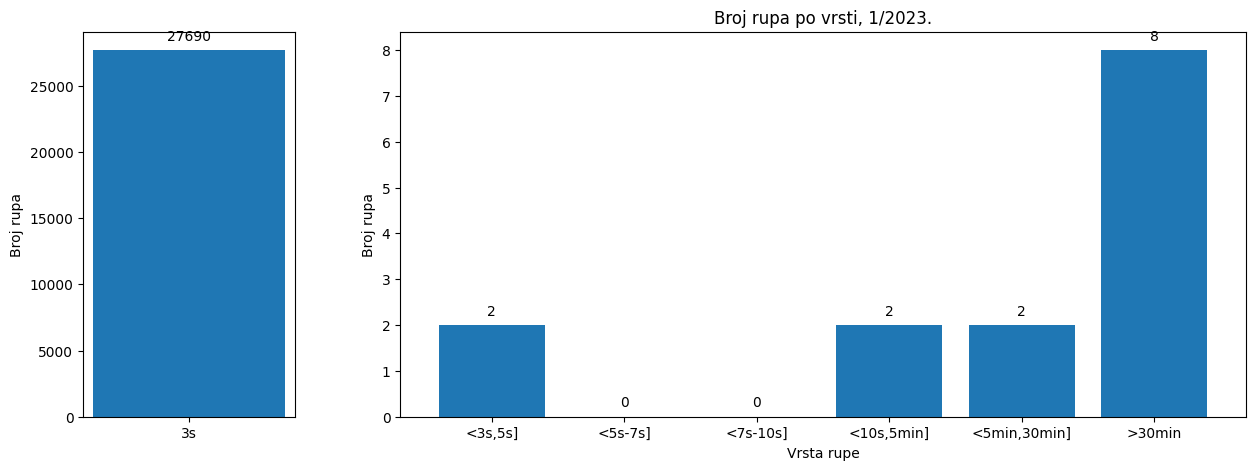

               start-time            end-time        duration
0     2023-02-01 00:01:30 2023-02-01 00:01:33 0 days 00:00:03
1     2023-02-01 00:03:17 2023-02-01 00:03:20 0 days 00:00:03
2     2023-02-01 00:05:30 2023-02-01 00:05:33 0 days 00:00:03
3     2023-02-01 00:07:17 2023-02-01 00:07:20 0 days 00:00:03
4     2023-02-01 00:09:14 2023-02-01 00:09:17 0 days 00:00:03
...                   ...                 ...             ...
19548 2023-02-21 09:14:32 2023-02-21 09:14:35 0 days 00:00:03
19549 2023-02-21 09:16:53 2023-02-21 09:16:56 0 days 00:00:03
19550 2023-02-21 09:19:16 2023-02-21 09:19:19 0 days 00:00:03
19551 2023-02-21 09:21:25 2023-02-21 09:21:28 0 days 00:00:03
19552 2023-02-21 09:22:18 2023-02-28 23:59:59 7 days 14:37:41

[19553 rows x 3 columns]


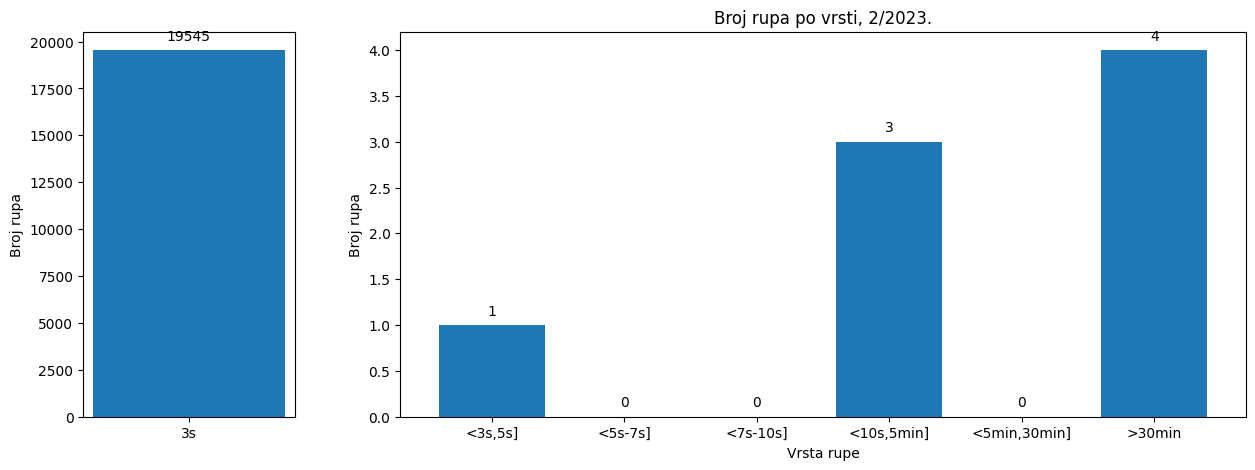

               start-time            end-time        duration
0     2023-03-01 00:00:01 2023-03-01 00:00:04 0 days 00:00:03
1     2023-03-01 00:02:02 2023-03-01 00:02:05 0 days 00:00:03
2     2023-03-01 00:03:27 2023-03-01 00:03:30 0 days 00:00:03
3     2023-03-01 00:05:48 2023-03-01 00:05:51 0 days 00:00:03
4     2023-03-01 00:07:39 2023-03-01 00:07:42 0 days 00:00:03
...                   ...                 ...             ...
18301 2023-03-30 16:15:50 2023-03-30 16:15:53 0 days 00:00:03
18302 2023-03-30 16:17:47 2023-03-30 16:17:50 0 days 00:00:03
18303 2023-03-30 16:18:52 2023-03-30 16:18:55 0 days 00:00:03
18304 2023-03-30 16:19:43 2023-03-30 16:19:46 0 days 00:00:03
18305 2023-03-30 16:20:32 2023-03-31 23:59:59 1 days 07:39:27

[18306 rows x 3 columns]


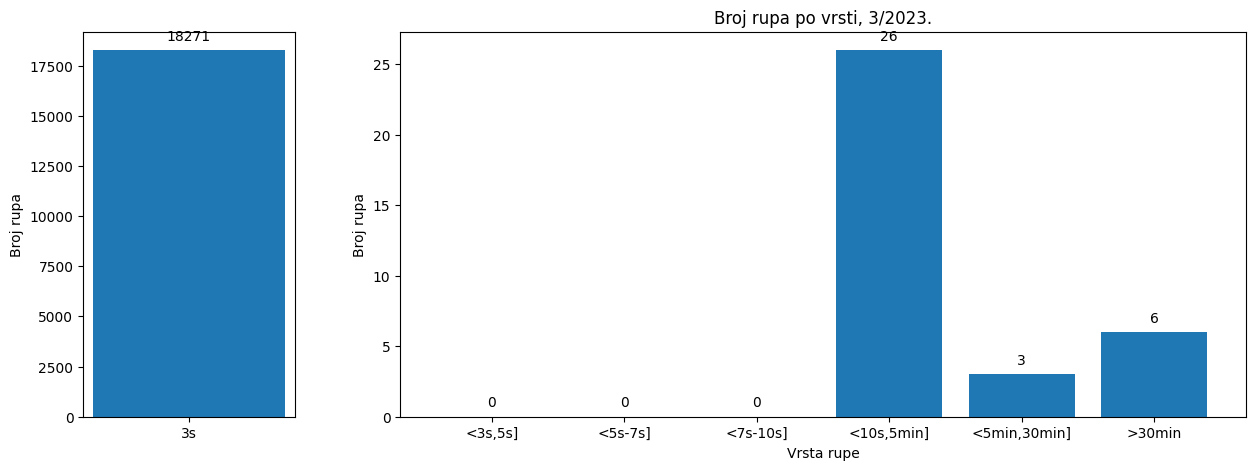

               start-time            end-time        duration
0     2023-04-01 00:00:01 2023-04-01 00:00:04 0 days 00:00:03
1     2023-04-01 00:02:12 2023-04-01 00:02:15 0 days 00:00:03
2     2023-04-01 00:04:17 2023-04-01 00:04:20 0 days 00:00:03
3     2023-04-01 00:06:12 2023-04-01 00:06:15 0 days 00:00:03
4     2023-04-01 00:08:51 2023-04-01 00:08:54 0 days 00:00:03
...                   ...                 ...             ...
74563 2023-04-29 23:58:16 2023-04-29 23:58:19 0 days 00:00:03
74564 2023-04-29 23:58:45 2023-04-29 23:58:48 0 days 00:00:03
74565 2023-04-29 23:59:16 2023-04-29 23:59:19 0 days 00:00:03
74566 2023-04-29 23:59:45 2023-04-29 23:59:48 0 days 00:00:03
74567 2023-04-30 00:00:00 2023-04-30 23:59:59 0 days 23:59:59

[74568 rows x 3 columns]


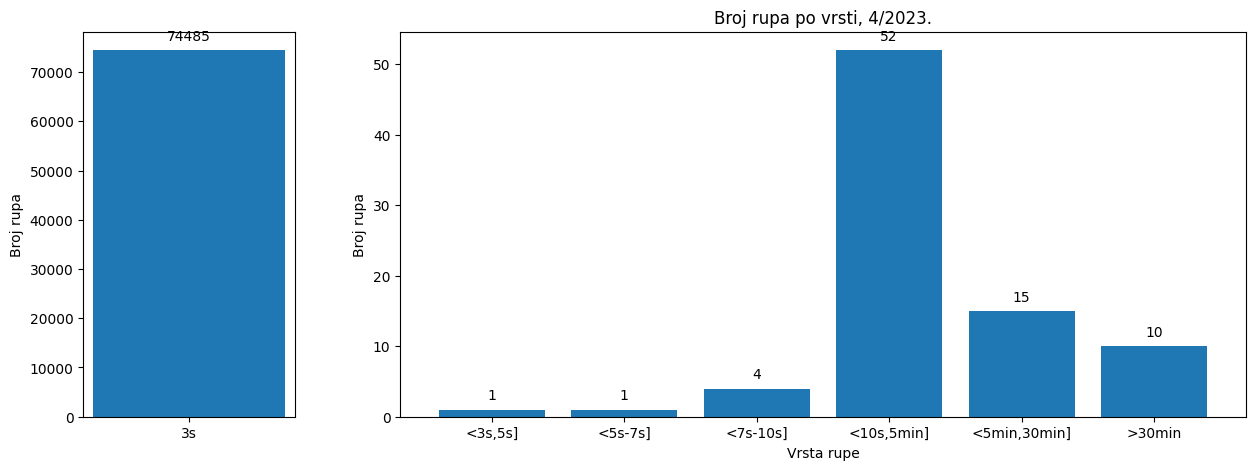

               start-time            end-time        duration
0     2023-05-01 00:00:23 2023-05-01 00:00:26 0 days 00:00:03
1     2023-05-01 00:00:54 2023-05-01 00:00:57 0 days 00:00:03
2     2023-05-01 00:01:21 2023-05-01 00:01:24 0 days 00:00:03
3     2023-05-01 00:01:52 2023-05-01 00:01:55 0 days 00:00:03
4     2023-05-01 00:02:19 2023-05-01 00:02:22 0 days 00:00:03
...                   ...                 ...             ...
93297 2023-05-30 23:58:15 2023-05-30 23:58:18 0 days 00:00:03
93298 2023-05-30 23:58:42 2023-05-30 23:58:45 0 days 00:00:03
93299 2023-05-30 23:59:07 2023-05-30 23:59:10 0 days 00:00:03
93300 2023-05-30 23:59:34 2023-05-30 23:59:37 0 days 00:00:03
93301 2023-05-30 23:59:59 2023-05-31 23:59:59 1 days 00:00:00

[93302 rows x 3 columns]


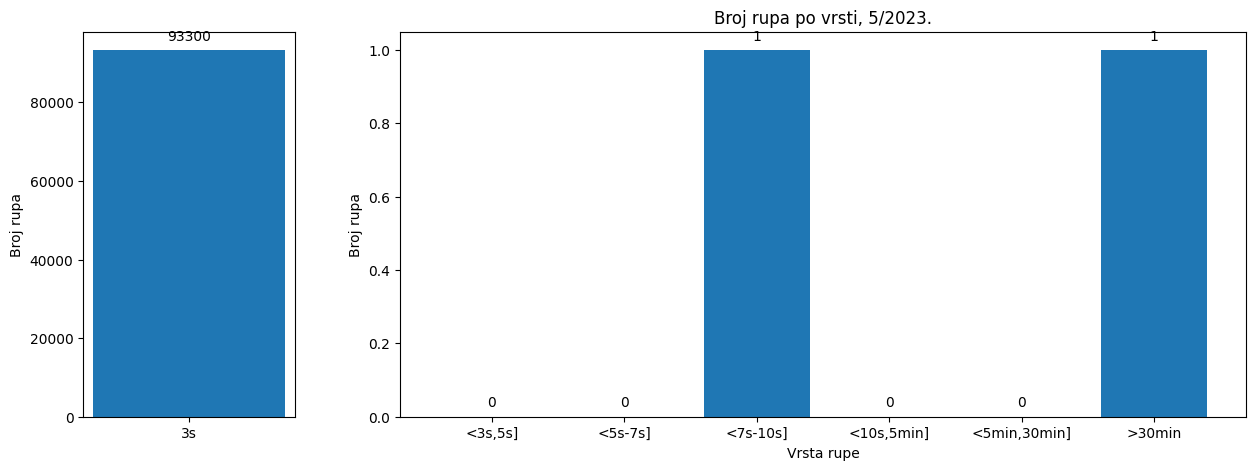

               start-time            end-time        duration
0     2023-06-01 00:00:14 2023-06-01 00:00:17 0 days 00:00:03
1     2023-06-01 00:00:39 2023-06-01 00:00:42 0 days 00:00:03
2     2023-06-01 00:01:08 2023-06-01 00:01:11 0 days 00:00:03
3     2023-06-01 00:01:33 2023-06-01 00:01:36 0 days 00:00:03
4     2023-06-01 00:02:00 2023-06-01 00:02:03 0 days 00:00:03
...                   ...                 ...             ...
87824 2023-06-29 23:58:18 2023-06-29 23:58:21 0 days 00:00:03
87825 2023-06-29 23:58:41 2023-06-29 23:58:44 0 days 00:00:03
87826 2023-06-29 23:59:08 2023-06-29 23:59:11 0 days 00:00:03
87827 2023-06-29 23:59:35 2023-06-29 23:59:38 0 days 00:00:03
87828 2023-06-30 00:00:00 2023-06-30 23:59:59 0 days 23:59:59

[87829 rows x 3 columns]


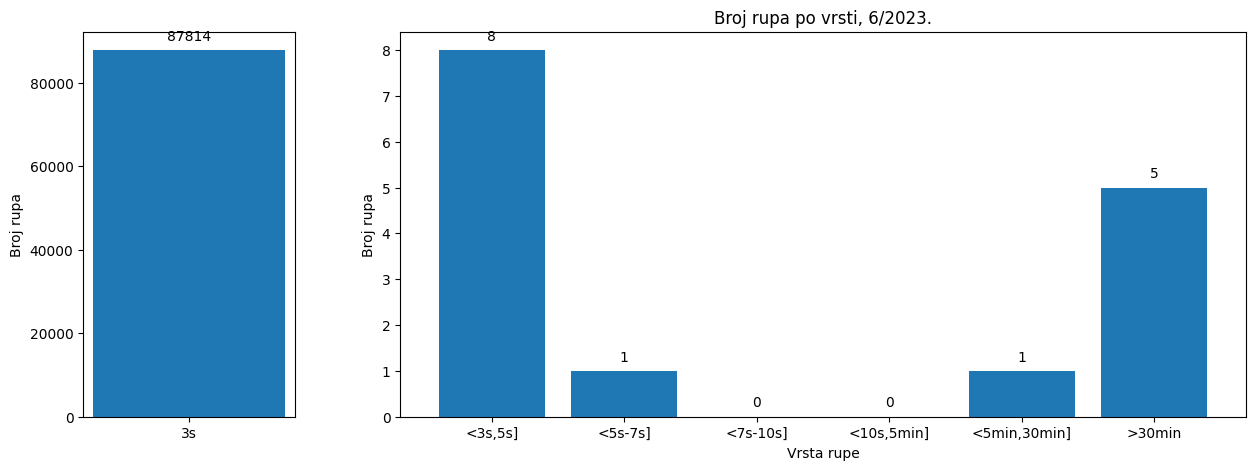

               start-time            end-time        duration
0     2023-07-01 00:00:01 2023-07-01 00:00:04 0 days 00:00:03
1     2023-07-01 00:00:26 2023-07-01 00:00:29 0 days 00:00:03
2     2023-07-01 00:00:49 2023-07-01 00:00:52 0 days 00:00:03
3     2023-07-01 00:01:22 2023-07-01 00:01:25 0 days 00:00:03
4     2023-07-01 00:01:45 2023-07-01 00:01:48 0 days 00:00:03
...                   ...                 ...             ...
91293 2023-07-30 23:58:17 2023-07-30 23:58:20 0 days 00:00:03
91294 2023-07-30 23:58:44 2023-07-30 23:58:47 0 days 00:00:03
91295 2023-07-30 23:59:09 2023-07-30 23:59:12 0 days 00:00:03
91296 2023-07-30 23:59:36 2023-07-30 23:59:39 0 days 00:00:03
91297 2023-07-30 23:59:59 2023-07-31 23:59:59 1 days 00:00:00

[91298 rows x 3 columns]


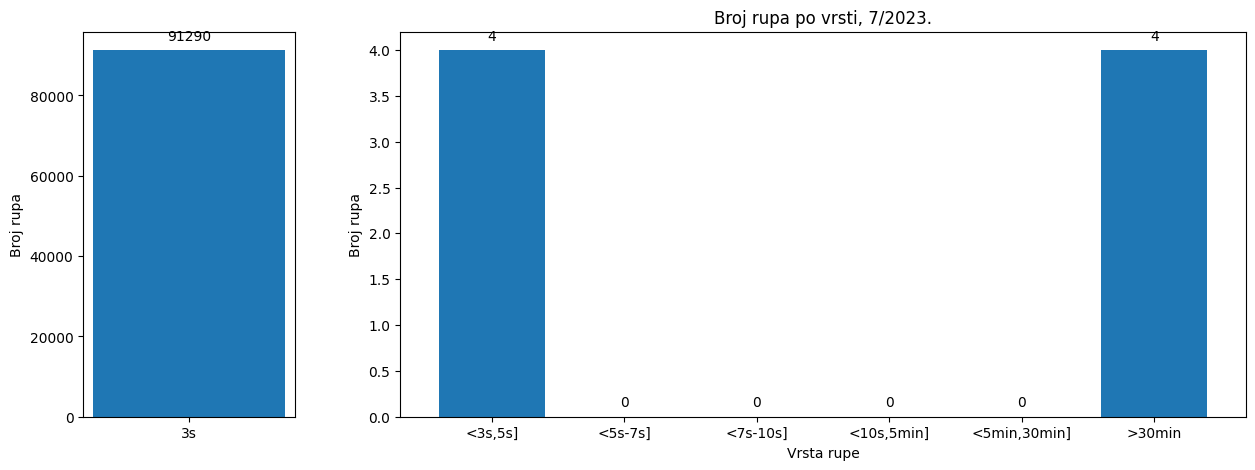

               start-time            end-time        duration
0     2023-08-01 00:00:02 2023-08-01 00:00:05 0 days 00:00:03
1     2023-08-01 00:00:27 2023-08-01 00:00:30 0 days 00:00:03
2     2023-08-01 00:00:54 2023-08-01 00:00:57 0 days 00:00:03
3     2023-08-01 00:01:19 2023-08-01 00:01:22 0 days 00:00:03
4     2023-08-01 00:01:44 2023-08-01 00:01:47 0 days 00:00:03
...                   ...                 ...             ...
83366 2023-08-30 23:58:06 2023-08-30 23:58:09 0 days 00:00:03
83367 2023-08-30 23:58:41 2023-08-30 23:58:44 0 days 00:00:03
83368 2023-08-30 23:59:14 2023-08-30 23:59:17 0 days 00:00:03
83369 2023-08-30 23:59:49 2023-08-30 23:59:52 0 days 00:00:03
83370 2023-08-31 00:00:00 2023-08-31 23:59:59 0 days 23:59:59

[83371 rows x 3 columns]


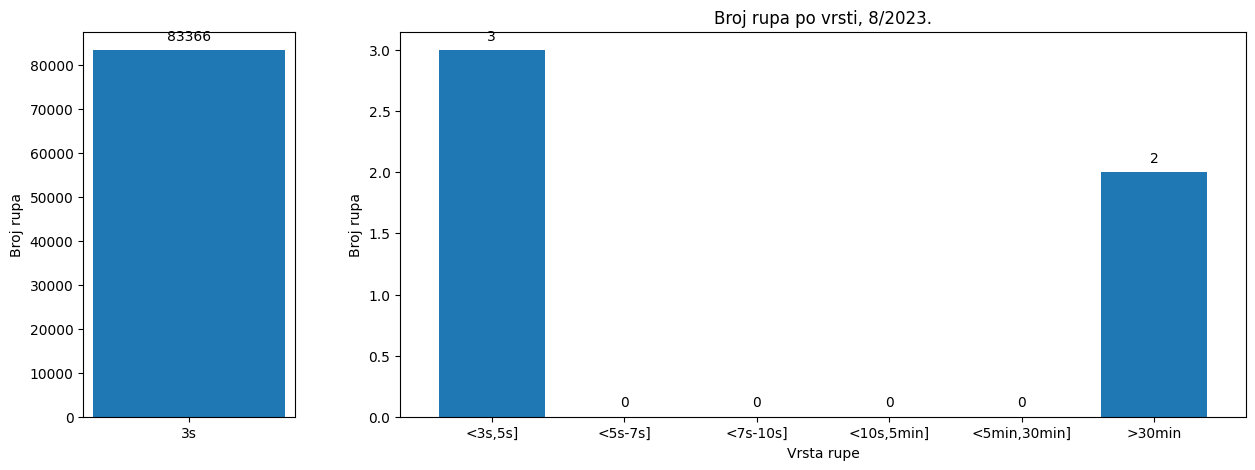

               start-time            end-time        duration
0     2023-09-01 00:00:05 2023-09-01 00:00:08 0 days 00:00:03
1     2023-09-01 00:00:36 2023-09-01 00:00:39 0 days 00:00:03
2     2023-09-01 00:01:09 2023-09-01 00:01:12 0 days 00:00:03
3     2023-09-01 00:01:40 2023-09-01 00:01:43 0 days 00:00:03
4     2023-09-01 00:02:13 2023-09-01 00:02:16 0 days 00:00:03
...                   ...                 ...             ...
63554 2023-09-29 23:58:20 2023-09-29 23:58:23 0 days 00:00:03
63555 2023-09-29 23:58:45 2023-09-29 23:58:48 0 days 00:00:03
63556 2023-09-29 23:59:10 2023-09-29 23:59:13 0 days 00:00:03
63557 2023-09-29 23:59:35 2023-09-29 23:59:38 0 days 00:00:03
63558 2023-09-29 23:59:58 2023-09-30 23:59:59 1 days 00:00:01

[63559 rows x 3 columns]


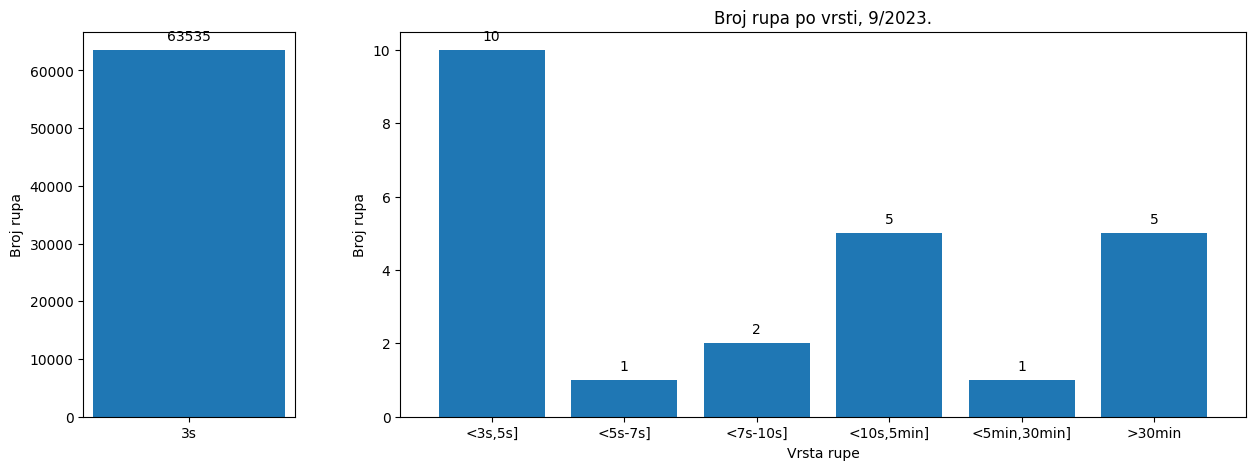

               start-time            end-time        duration
0     2023-10-01 00:00:00 2023-10-02 10:04:26 1 days 10:04:26
1     2023-10-02 10:04:40 2023-10-02 10:04:43 0 days 00:00:03
2     2023-10-02 10:05:07 2023-10-02 10:05:10 0 days 00:00:03
3     2023-10-02 10:05:34 2023-10-02 10:05:37 0 days 00:00:03
4     2023-10-02 10:06:01 2023-10-02 10:06:04 0 days 00:00:03
...                   ...                 ...             ...
92202 2023-10-30 23:58:27 2023-10-30 23:58:30 0 days 00:00:03
92203 2023-10-30 23:58:52 2023-10-30 23:58:55 0 days 00:00:03
92204 2023-10-30 23:59:15 2023-10-30 23:59:18 0 days 00:00:03
92205 2023-10-30 23:59:42 2023-10-30 23:59:45 0 days 00:00:03
92206 2023-10-30 23:59:59 2023-10-31 23:59:59 1 days 00:00:00

[92207 rows x 3 columns]


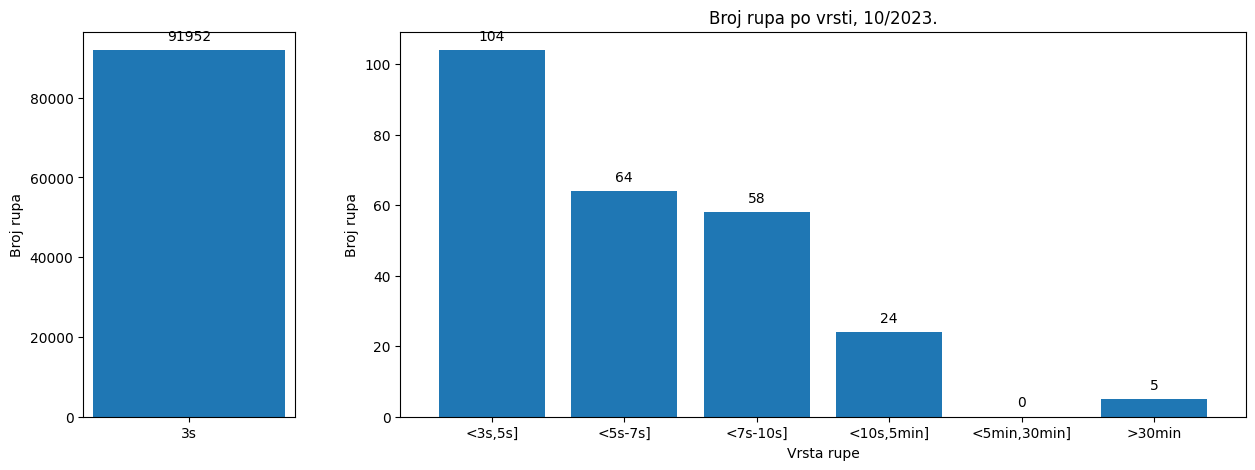

               start-time            end-time        duration
0     2023-11-01 00:00:03 2023-11-01 00:00:06 0 days 00:00:03
1     2023-11-01 00:00:30 2023-11-01 00:00:33 0 days 00:00:03
2     2023-11-01 00:00:55 2023-11-01 00:00:58 0 days 00:00:03
3     2023-11-01 00:01:20 2023-11-01 00:01:23 0 days 00:00:03
4     2023-11-01 00:01:43 2023-11-01 00:01:46 0 days 00:00:03
...                   ...                 ...             ...
90344 2023-11-29 23:58:19 2023-11-29 23:58:22 0 days 00:00:03
90345 2023-11-29 23:58:44 2023-11-29 23:58:47 0 days 00:00:03
90346 2023-11-29 23:59:11 2023-11-29 23:59:14 0 days 00:00:03
90347 2023-11-29 23:59:38 2023-11-29 23:59:41 0 days 00:00:03
90348 2023-11-29 23:59:59 2023-11-30 23:59:59 1 days 00:00:00

[90349 rows x 3 columns]


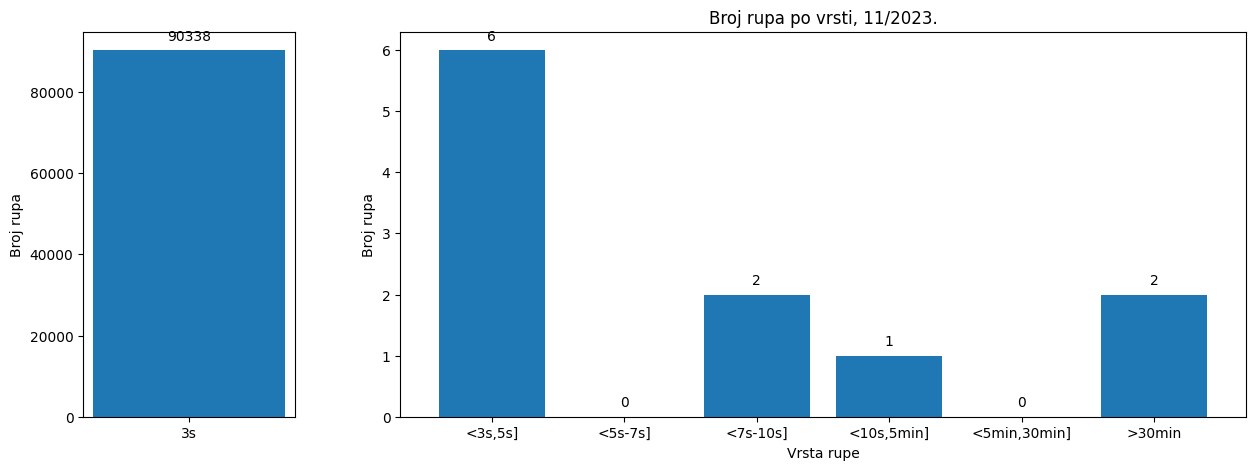

In [15]:
for i in range(1,12):
    tablica_rupa=obrada(i,2023,pd.to_timedelta('00:00:02'))
    data = {
        'Veličina rupe': ['3s','<3s,5s]','<5s-7s]','<7s-10s]','<10s,5min]', '<5min,30min]', '>30min'],
        'Broj rupa': [
            tablica_rupa[(tablica_rupa['duration'] == pd.to_timedelta('00:00:03'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:00:03')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:00:05'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:00:05')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:00:07'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:00:07')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:00:10'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:00:10')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:05:00'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:05:00')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:30:00'))].shape[0],
            tablica_rupa[tablica_rupa['duration'] > pd.to_timedelta('00:30:00')].shape[0]
        ]
    }
    rupe = pd.DataFrame(data, columns=['Broj rupa', 'Veličina rupe'])
   
    # Adjusting layout for better spacing
    df_subset = rupe.head(1)
    df_subset2 = rupe.tail(6)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={'width_ratios': [1, 4]})
    
    ax1.bar(df_subset['Veličina rupe'], df_subset['Broj rupa'], width=0.1, align='center')
    ax1.set_ylabel('Broj rupa')
    for p in ax1.patches:
        ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Plotting the second subplot (last six rows)
    
    # Plotting the second subplot (last four rows)
    ax2.bar(df_subset2['Veličina rupe'], df_subset2['Broj rupa'])
    ax2.set_xlabel('Vrsta rupe')
    ax2.set_ylabel('Broj rupa')
    for p in ax2.patches:
        ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plt.title("Broj rupa po vrsti, {}/{}.".format(i,2023)) 

    # Adjusting layout for better spacing
    plt.savefig("{}_{}_rupe.png".format(i,2023), dpi=600, bbox_inches='tight')
    plt.show()
    
    

In [34]:
tablica_rupa=obrada(i,2023,pd.to_timedelta('00:00:02'))

               start-time            end-time        duration
0     2023-11-01 00:00:03 2023-11-01 00:00:06 0 days 00:00:03
1     2023-11-01 00:00:30 2023-11-01 00:00:33 0 days 00:00:03
2     2023-11-01 00:00:55 2023-11-01 00:00:58 0 days 00:00:03
3     2023-11-01 00:01:20 2023-11-01 00:01:23 0 days 00:00:03
4     2023-11-01 00:01:43 2023-11-01 00:01:46 0 days 00:00:03
...                   ...                 ...             ...
90344 2023-11-29 23:58:19 2023-11-29 23:58:22 0 days 00:00:03
90345 2023-11-29 23:58:44 2023-11-29 23:58:47 0 days 00:00:03
90346 2023-11-29 23:59:11 2023-11-29 23:59:14 0 days 00:00:03
90347 2023-11-29 23:59:38 2023-11-29 23:59:41 0 days 00:00:03
90348 2023-11-29 23:59:59 2023-11-30 23:59:59 1 days 00:00:00

[90349 rows x 3 columns]


In [36]:
#vrste rupa: 3-10s, 10s-5 min, 5min-30 min, vise od 30 min
data = {
    'Veličina rupe': ['3s','[3s,5s>','[5s-7s>','[7s-10s>','[10s,5min>', '[5min,30min>', '>=30min'],
    'Broj rupa': [
        tablica_rupa[(tablica_rupa['duration'] == pd.to_timedelta('00:00:03'))].shape[0],
        tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:00:03')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:00:05'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:00:05')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:00:07'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:00:07')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:00:10'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:00:10')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:05:00'))].shape[0],
            tablica_rupa[(tablica_rupa['duration'] > pd.to_timedelta('00:05:00')) & (tablica_rupa['duration'] <= pd.to_timedelta('00:30:00'))].shape[0],
            tablica_rupa[tablica_rupa['duration'] > pd.to_timedelta('00:30:00')].shape[0]
    ]
}
rupe = pd.DataFrame(data, columns=['Broj rupa', 'Veličina rupe'])
print(rupe)

   Broj rupa Veličina rupe
0      90338            3s
1          6       [3s,5s>
2          0       [5s-7s>
3          2      [7s-10s>
4          1    [10s,5min>
5          0  in,30min>
6          2       >=30min


In [18]:
obrada(6,2022,pd.to_timedelta('00:00:06'))

            start-time            end-time        duration
0  2022-06-01 12:41:04 2022-06-01 17:33:55 0 days 04:52:51
1  2022-06-03 09:48:20 2022-06-03 09:48:58 0 days 00:00:38
2  2022-06-03 10:23:55 2022-06-03 12:45:44 0 days 02:21:49
3  2022-06-03 13:30:17 2022-06-03 13:48:18 0 days 00:18:01
4  2022-06-03 13:48:53 2022-06-03 13:49:22 0 days 00:00:29
5  2022-06-03 14:05:01 2022-06-03 14:27:09 0 days 00:22:08
6  2022-06-03 14:32:39 2022-06-03 14:32:49 0 days 00:00:10
7  2022-06-03 15:39:56 2022-06-03 15:44:40 0 days 00:04:44
8  2022-06-03 15:45:33 2022-06-03 16:01:45 0 days 00:16:12
9  2022-06-03 17:19:03 2022-06-03 17:56:51 0 days 00:37:48
10 2022-06-03 19:58:24 2022-06-05 23:58:32 2 days 04:00:08
11 2022-06-09 16:33:11 2022-06-09 16:33:22 0 days 00:00:11
12 2022-06-11 13:20:43 2022-06-13 09:14:57 1 days 19:54:14
13 2022-06-23 10:53:39 2022-06-30 23:59:59 7 days 13:06:20


,start-time,end-time,duration
0,2022-06-01 12:41:04,2022-06-01 17:33:55,0 days 04:52:51
1,2022-06-03 09:48:20,2022-06-03 09:48:58,0 days 00:00:38
2,2022-06-03 10:23:55,2022-06-03 12:45:44,0 days 02:21:49
3,2022-06-03 13:30:17,2022-06-03 13:48:18,0 days 00:18:01
4,2022-06-03 13:48:53,2022-06-03 13:49:22,0 days 00:00:29
5,2022-06-03 14:05:01,2022-06-03 14:27:09,0 days 00:22:08
6,2022-06-03 14:32:39,2022-06-03 14:32:49,0 days 00:00:10
7,2022-06-03 15:39:56,2022-06-03 15:44:40,0 days 00:04:44
8,2022-06-03 15:45:33,2022-06-03 16:01:45,0 days 00:16:12
9,2022-06-03 17:19:03,2022-06-03 17:56:51,0 days 00:37:48
